# Test of different models

## Logistic regression

In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données (adaptez le chemin selon votre fichier)
# Exemple pour les données de prévalence COPD
df = pd.read_csv('../exploratory_data_analysis/data/Refined/1721/COPD_prevalence.csv')

# Affichage des premières lignes pour vérifier les noms de colonnes
print("Aperçu des données :")
print(df.head())
print("\nNoms des colonnes :")
print(df.columns.tolist())
print("\nTypes de données :")
print(df.dtypes)

Aperçu des données :
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
4  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  2015  1588.006576          IDN   
1  2015  1588.006576          IDN   
2  2015  1588.006576          IDN   
3  2017  1646.266156          IDN   
4  2018  1680.660819          IDN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                               67.3                     
1                                               67.3                     
2                                               67.3                     
3  

In [2]:
# Étape 1 : Tri des données par Location et Period
# Assurez-vous d'adapter les noms de colonnes selon votre DataFrame
# (Location ou Country, Period ou Year)

# Supposons que les colonnes sont 'Location' et 'Period'
# Si vos colonnes ont d'autres noms, modifiez-les ici
location_col = 'Country Name'  # ou 'Country'
period_col = 'Year'      # ou 'Year'
value_col = 'Value'        # Colonne contenant le taux

# Vérifier que les colonnes existent
if location_col not in df.columns or period_col not in df.columns or value_col not in df.columns:
    print("⚠️ Attention : Veuillez vérifier les noms de colonnes !")
    print(f"Colonnes disponibles : {df.columns.tolist()}")
else:
    # Tri des données
    df = df.sort_values([location_col, period_col]).reset_index(drop=True)
    print(f"✓ Données triées par {location_col} puis {period_col}")
    print(f"Nombre de lignes : {len(df)}")
    print(f"Nombre de pays/régions : {df[location_col].nunique()}")
    print(f"Période : {df[period_col].min()} - {df[period_col].max()}")

✓ Données triées par Country Name puis Year
Nombre de lignes : 1131
Nombre de pays/régions : 47
Période : 2010 - 2021


In [3]:
# Étape 2 : Calcul de la différence par rapport à l'année précédente
# La méthode groupby().diff() calcule automatiquement la différence
# avec la ligne précédente au sein de chaque groupe

df['value_diff'] = df.groupby(location_col)[value_col].diff()

print("✓ Colonne 'value_diff' créée")
print(f"\nExemple pour un pays (les 10 premières lignes) :")
print(df[[location_col, period_col, value_col, 'value_diff']].head(10))

✓ Colonne 'value_diff' créée

Exemple pour un pays (les 10 premières lignes) :
  Country Name  Year        Value  value_diff
0      Albania  2015  3263.566286         NaN
1      Albania  2016  3415.349428  151.783142
2      Albania  2017  3561.038801  145.689373
3      Albania  2018  3619.240209   58.201408
4      Albania  2019  3732.947927  113.707717
5      Albania  2020  3946.051306  213.103380
6    Australia  2012  3367.843421         NaN
7    Australia  2013  3353.098308  -14.745113
8    Australia  2013  3353.098308    0.000000
9    Australia  2013  3353.098308    0.000000


In [4]:
# Étape 3 : Création de la variable cible Y (CLASSIFICATION BINAIRE)
# Définition du seuil de stagnation
threshold = 0.0  # Ajustez ce seuil selon vos besoins (ex: 0.0, 0.001, 0.01, etc.)

print("="*80)
print("CRÉATION DE LA VARIABLE CIBLE Y - CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*80)
print(f"\n📊 Seuil de stagnation défini : {threshold}")
print("\nRègles de classification :")
print(f"  - Y = 0 ('Diminue')  si value_diff < -{threshold}")
print(f"  - Y = NaN ('Stagne') si -{threshold} <= value_diff <= {threshold} (SERA SUPPRIMÉ)")
print(f"  - Y = 1 ('Augmente') si value_diff > {threshold}")

# Création de la variable Y avec 3 classes temporairement
def classify_change(diff, threshold=0.0):
    if pd.isna(diff):
        return np.nan
    elif diff < -threshold:
        return 0  # Diminue
    elif diff > threshold:
        return 1  # Augmente (changé de 2 à 1 pour classification binaire)
    else:
        return np.nan  # Stagne - sera supprimé

# Application de la fonction de classification
df['Y'] = df['value_diff'].apply(lambda x: classify_change(x, threshold))

# Version avec labels textuels pour la lisibilité
df['Y_label'] = df['Y'].map({
    0: 'Diminue',
    1: 'Augmente'
})

print(f"\n✓ Variables cibles 'Y' et 'Y_label' créées")
print(f"   Nombre de valeurs NaN dans Y (inclut stagne) : {df['Y'].isna().sum()}")
print(f"   Nombre total de lignes : {len(df)}")
print("\n" + "="*80)


CRÉATION DE LA VARIABLE CIBLE Y - CLASSIFICATION BINAIRE (2 CLASSES)

📊 Seuil de stagnation défini : 0.0

Règles de classification :
  - Y = 0 ('Diminue')  si value_diff < -0.0
  - Y = NaN ('Stagne') si -0.0 <= value_diff <= 0.0 (SERA SUPPRIMÉ)
  - Y = 1 ('Augmente') si value_diff > 0.0

✓ Variables cibles 'Y' et 'Y_label' créées
   Nombre de valeurs NaN dans Y (inclut stagne) : 825
   Nombre total de lignes : 1131



In [5]:
# Étape 4 : Gestion des valeurs NaN
# Suppression des lignes où Y est NaN (première année de chaque pays + classe "Stagne")

print("Avant suppression des NaN :")
print(f"  Nombre total de lignes : {len(df)}")
print(f"  Nombre de NaN dans Y : {df['Y'].isna().sum()}")
print(f"  (inclut les valeurs 'Stagne' qui sont dans le threshold)")

# Création d'un nouveau DataFrame sans les NaN (supprime première année + Stagne)
df_clean = df.dropna(subset=['Y']).copy()

print("\nAprès suppression des NaN et de la classe 'Stagne' :")
print(f"  Nombre total de lignes : {len(df_clean)}")
print(f"  Nombre de NaN dans Y : {df_clean['Y'].isna().sum()}")

# Conversion de Y en entier
df_clean['Y'] = df_clean['Y'].astype(int)

print("\n✓ Données nettoyées et prêtes pour le Machine Learning (classification binaire)")
print("✓ Classe 'Stagne' supprimée - entraînement sur 2 classes uniquement")
print("="*80)


Avant suppression des NaN :
  Nombre total de lignes : 1131
  Nombre de NaN dans Y : 825
  (inclut les valeurs 'Stagne' qui sont dans le threshold)

Après suppression des NaN et de la classe 'Stagne' :
  Nombre total de lignes : 306
  Nombre de NaN dans Y : 0

✓ Données nettoyées et prêtes pour le Machine Learning (classification binaire)
✓ Classe 'Stagne' supprimée - entraînement sur 2 classes uniquement


In [6]:
# Étape 5 : Affichage de la distribution de la variable cible Y (2 CLASSES)

print("="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE Y - CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*80)

# Comptes absolus
print("\n1. Comptes (value_counts) :")
counts = df_clean['Y'].value_counts().sort_index()
print(counts)

# Pourcentages
print("\n2. Pourcentages :")
distribution_pct = df_clean['Y'].value_counts(normalize=True).sort_index() * 100
for classe, pct in distribution_pct.items():
    label = {0: 'Diminue', 1: 'Augmente'}[classe]
    print(f"   Classe {classe} ({label:9s}) : {pct:6.2f}%")

# Avec les labels
print("\n3. Distribution avec labels :")
label_counts = df_clean['Y_label'].value_counts()
print(label_counts)

# Statistiques de déséquilibre
print("\n4. Analyse du déséquilibre des classes :")
if len(counts) == 2:
    max_count = counts.max()
    min_count = counts.min()
    ratio = max_count / min_count
    print(f"   Classe la plus fréquente : {counts.idxmax()} ({counts.max()} observations)")
    print(f"   Classe la moins fréquente : {counts.idxmin()} ({counts.min()} observations)")
    print(f"   Ratio de déséquilibre : {ratio:.2f}:1")
    
    if ratio < 2:
        print("   ✓ Classes relativement équilibrées")
    elif ratio < 5:
        print("   ⚠️ Déséquilibre modéré - SMOTE recommandé")
    else:
        print("   ⚠️ Déséquilibre important - SMOTE fortement recommandé")

print("\n" + "="*80)


DISTRIBUTION DE LA VARIABLE CIBLE Y - CLASSIFICATION BINAIRE (2 CLASSES)

1. Comptes (value_counts) :
Y
0     54
1    252
Name: count, dtype: int64

2. Pourcentages :
   Classe 0 (Diminue  ) :  17.65%
   Classe 1 (Augmente ) :  82.35%

3. Distribution avec labels :
Y_label
Augmente    252
Diminue      54
Name: count, dtype: int64

4. Analyse du déséquilibre des classes :
   Classe la plus fréquente : 1 (252 observations)
   Classe la moins fréquente : 0 (54 observations)
   Ratio de déséquilibre : 4.67:1
   ⚠️ Déséquilibre modéré - SMOTE recommandé



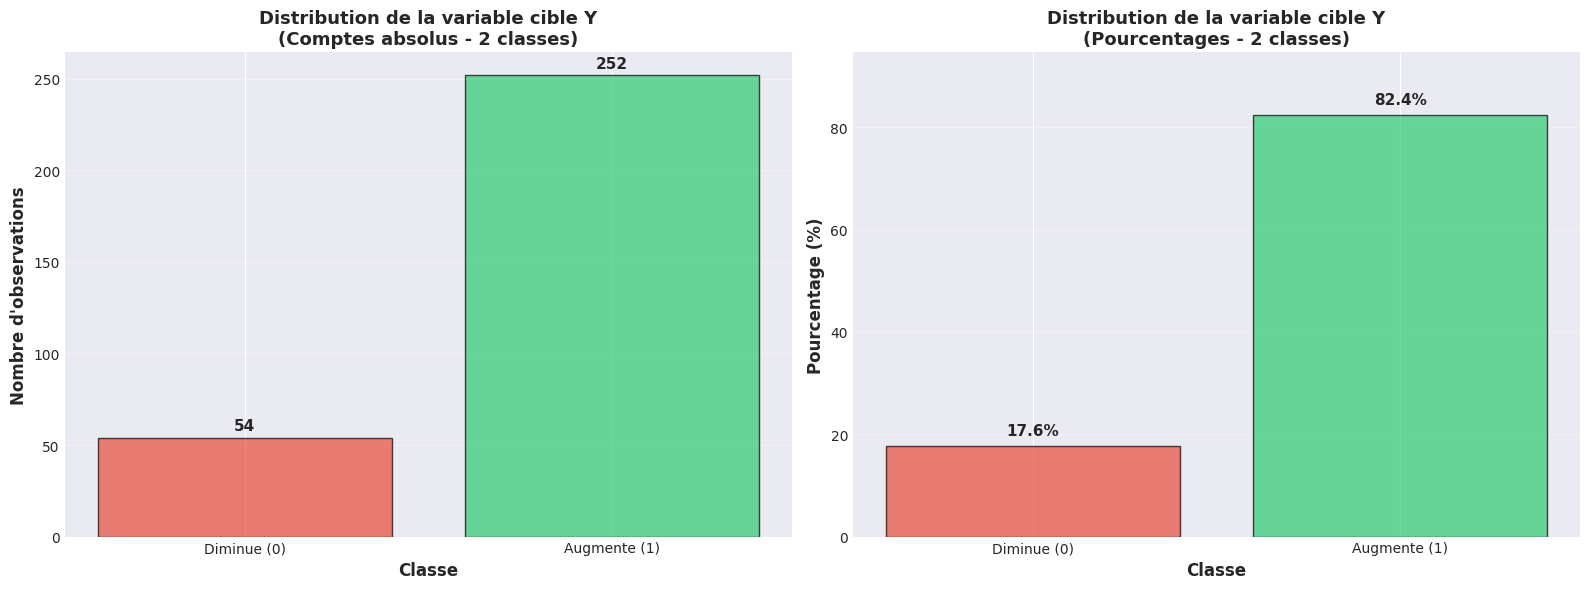


✓ Visualisation créée avec succès pour les 2 classes !
✓ Classe 'Stagne' supprimée du dataset


In [7]:
# Étape 6 : Visualisation de la distribution (2 CLASSES)

# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Bar plot avec comptes absolus
counts = df_clean['Y'].value_counts().sort_index()
colors = ['#e74c3c', '#2ecc71']  # Rouge (Diminue), Vert (Augmente)
labels_text = ['Diminue (0)', 'Augmente (1)']

axes[0].bar(counts.index, counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution de la variable cible Y\n(Comptes absolus - 2 classes)', 
                   fontsize=13, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(labels_text, rotation=0, ha='center')
axes[0].grid(axis='y', alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(counts.values):
    axes[0].text(i, v + max(counts.values)*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Graphique 2 : Pourcentages
pct = df_clean['Y'].value_counts(normalize=True).sort_index() * 100
axes[1].bar(pct.index, pct.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution de la variable cible Y\n(Pourcentages - 2 classes)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(labels_text, rotation=0, ha='center')
axes[1].set_ylim([0, max(pct.values) * 1.15])
axes[1].grid(axis='y', alpha=0.3)

# Ajout des pourcentages au-dessus des barres
for i, v in enumerate(pct.values):
    axes[1].text(i, v + max(pct.values)*0.02, f'{v:.1f}%', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Visualisation créée avec succès pour les 2 classes !")
print("✓ Classe 'Stagne' supprimée du dataset")
print("="*80)


## Vérification et exploration supplémentaire

Quelques vérifications utiles avant de passer à la modélisation :

In [8]:
# Vérification : Afficher quelques exemples pour chaque pays
print("Exemples de données avec la variable cible Y :\n")

# Sélectionner quelques pays pour l'illustration
sample_locations = df_clean[location_col].unique()[:3]

for loc in sample_locations:
    print(f"\n{'='*60}")
    print(f"Pays/Région : {loc}")
    print('='*60)
    sample_data = df_clean[df_clean[location_col] == loc][[
        location_col, period_col, value_col, 'value_diff', 'Y', 'Y_label'
    ]].head(10)
    print(sample_data.to_string(index=False))
    print()

Exemples de données avec la variable cible Y :


Pays/Région : Albania
Country Name  Year       Value  value_diff  Y  Y_label
     Albania  2016 3415.349428  151.783142  1 Augmente
     Albania  2017 3561.038801  145.689373  1 Augmente
     Albania  2018 3619.240209   58.201408  1 Augmente
     Albania  2019 3732.947927  113.707717  1 Augmente
     Albania  2020 3946.051306  213.103380  1 Augmente


Pays/Région : Australia
Country Name  Year       Value  value_diff  Y  Y_label
   Australia  2013 3353.098308  -14.745113  0  Diminue
   Australia  2014 3361.027233    7.928924  1 Augmente
   Australia  2015 3379.711188   18.683955  1 Augmente
   Australia  2016 3403.269497   23.558309  1 Augmente
   Australia  2017 3440.250187   36.980690  1 Augmente
   Australia  2018 3464.470860   24.220673  1 Augmente
   Australia  2019 3510.745773   46.274913  1 Augmente


Pays/Région : Austria
Country Name  Year       Value  value_diff  Y  Y_label
     Austria  2014 5526.320739   22.806962  1 Augmente

Statistiques de la variable 'value_diff' :
count    306.000000
mean      39.033084
std       46.425773
min     -129.763283
25%       10.798574
50%       36.395601
75%       58.656265
max      284.641669
Name: value_diff, dtype: float64


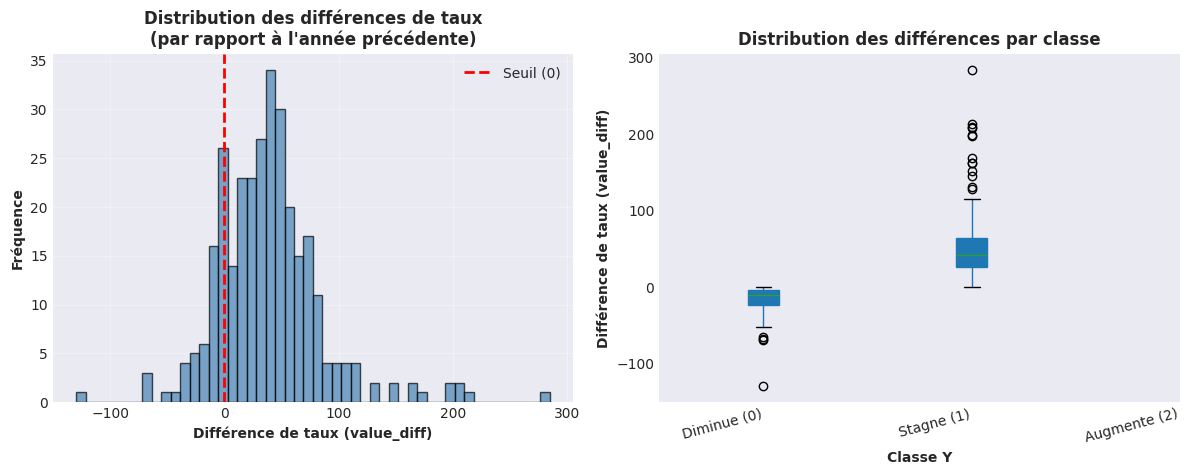

In [9]:
# Statistiques descriptives de la différence value_diff
print("Statistiques de la variable 'value_diff' :")
print(df_clean['value_diff'].describe())

# Distribution de value_diff
plt.figure(figsize=(12, 5))

# Histogramme
plt.subplot(1, 2, 1)
plt.hist(df_clean['value_diff'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil (0)')
plt.xlabel('Différence de taux (value_diff)', fontweight='bold')
plt.ylabel('Fréquence', fontweight='bold')
plt.title('Distribution des différences de taux\n(par rapport à l\'année précédente)', 
          fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot pour les 3 classes
plt.subplot(1, 2, 2)
df_clean.boxplot(column='value_diff', by='Y', ax=plt.gca(), 
                 patch_artist=True, grid=False)
plt.suptitle('')  # Supprimer le titre auto-généré
plt.xlabel('Classe Y', fontweight='bold')
plt.ylabel('Différence de taux (value_diff)', fontweight='bold')
plt.title('Distribution des différences par classe', fontweight='bold')
plt.xticks([1, 2, 3], ['Diminue (0)', 'Stagne (1)', 'Augmente (2)'], rotation=15, ha='right')

plt.tight_layout()
plt.show()

## Sauvegarde des données préparées

Le DataFrame `df_clean` est maintenant prêt pour la modélisation de Machine Learning.

In [10]:
# Sauvegarde optionnelle des données préparées
# df_clean.to_csv('COPD_prepared_for_classification_binary.csv', index=False)
# print("✓ Données sauvegardées dans 'COPD_prepared_for_classification_binary.csv'")

# Résumé final
print("\n" + "="*80)
print("RÉSUMÉ DE LA PRÉPARATION DES DONNÉES - CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*80)
print(f"DataFrame original (df) : {len(df)} lignes")
print(f"DataFrame nettoyé (df_clean) : {len(df_clean)} lignes")
print(f"Lignes supprimées (première année + Stagne) : {len(df) - len(df_clean)}")
print(f"Nombre de pays/régions : {df_clean[location_col].nunique()}")
print(f"Période couverte : {df_clean[period_col].min()} - {df_clean[period_col].max()}")
print(f"\nVariable cible 'Y' (2 classes) :")
print(f"  - 0 (Diminue)  : {(df_clean['Y'] == 0).sum()} observations ({(df_clean['Y'] == 0).sum() / len(df_clean) * 100:.1f}%)")
print(f"  - 1 (Augmente) : {(df_clean['Y'] == 1).sum()} observations ({(df_clean['Y'] == 1).sum() / len(df_clean) * 100:.1f}%)")
print("\n✓ Les données sont prêtes pour l'entraînement de modèles de classification binaire !")
print("✓ Classe 'Stagne' exclue de l'entraînement")
print("="*80)



RÉSUMÉ DE LA PRÉPARATION DES DONNÉES - CLASSIFICATION BINAIRE (2 CLASSES)
DataFrame original (df) : 1131 lignes
DataFrame nettoyé (df_clean) : 306 lignes
Lignes supprimées (première année + Stagne) : 825
Nombre de pays/régions : 44
Période couverte : 2011 - 2021

Variable cible 'Y' (2 classes) :
  - 0 (Diminue)  : 54 observations (17.6%)
  - 1 (Augmente) : 252 observations (82.4%)

✓ Les données sont prêtes pour l'entraînement de modèles de classification binaire !
✓ Classe 'Stagne' exclue de l'entraînement


## Correction du déséquilibre des classes avec SMOTE

Le déséquilibre des classes peut causer des problèmes de performance, notamment un mauvais rappel pour la classe minoritaire. Nous allons utiliser **SMOTE** (Synthetic Minority Over-sampling Technique) pour générer des échantillons synthétiques de la classe minoritaire.

**Important** : 
- SMOTE sera appliqué **uniquement sur l'ensemble d'entraînement** pour éviter la fuite de données (data leakage).
- Nous travaillons avec **2 classes uniquement** : Diminue (0) et Augmente (1)
- La classe "Stagne" a été **supprimée** du dataset pour éviter qu'elle influence les modèles.


In [11]:
# Installation de la bibliothèque imbalanced-learn (si nécessaire)
# !pip install imbalanced-learn

# Import des bibliothèques pour SMOTE et classification binaire
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✓ Bibliothèques importées avec succès pour la classification binaire !")
print("="*80)


✓ Bibliothèques importées avec succès pour la classification binaire !


In [12]:
# Préparation des données pour la modélisation

# Créer une copie propre du DataFrame
df_model = df_clean.copy()

print("⚠️ Création de features pour la modélisation...")

# Création de features numériques basées sur les données temporelles
df_model['value_lag1'] = df_model.groupby(location_col)[value_col].shift(1)
df_model['value_lag2'] = df_model.groupby(location_col)[value_col].shift(2)
df_model['rolling_mean_3'] = df_model.groupby(location_col)[value_col].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df_model['rolling_std_3'] = df_model.groupby(location_col)[value_col].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
df_model['year_numeric'] = df_model[period_col]

# Encodage du pays (conversion de catégorique en numérique)
le_location = LabelEncoder()
df_model['location_encoded'] = le_location.fit_transform(df_model[location_col])

# Suppression des lignes avec NaN créées par les lags
df_model = df_model.dropna().reset_index(drop=True)

# Définition explicite des features numériques à utiliser
available_features = ['value_lag1', 'value_lag2', 'rolling_mean_3', 
                      'rolling_std_3', 'year_numeric', 'location_encoded']

print(f"✓ Features créées : {available_features}")

# Préparation de X et y - IMPORTANT : conversion explicite en valeurs numériques
X = df_model[available_features].copy()
y = df_model['Y'].copy()

# Vérification que toutes les colonnes sont bien numériques
print(f"\n📋 Vérification des types de données dans X :")
print(X.dtypes)

# Vérification qu'il n'y a pas de valeurs non-numériques
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric_cols) > 0:
    print(f"\n⚠️ ATTENTION : Colonnes non-numériques détectées : {non_numeric_cols}")
    print("Conversion en cours...")
    for col in non_numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.dropna()
    y = y.loc[X.index]
    print("✓ Conversion terminée")
else:
    print("✓ Toutes les colonnes sont numériques")

print(f"\n📊 Dimensions finales :")
print(f"  X : {X.shape}")
print(f"  y : {y.shape}")
print(f"\n📊 Distribution de y avant SMOTE :")
print(y.value_counts())
print(f"\nPourcentages :")
print(y.value_counts(normalize=True) * 100)

⚠️ Création de features pour la modélisation...
✓ Features créées : ['value_lag1', 'value_lag2', 'rolling_mean_3', 'rolling_std_3', 'year_numeric', 'location_encoded']

📋 Vérification des types de données dans X :
value_lag1          float64
value_lag2          float64
rolling_mean_3      float64
rolling_std_3       float64
year_numeric          int64
location_encoded      int64
dtype: object
✓ Toutes les colonnes sont numériques

📊 Dimensions finales :
  X : (78, 6)
  y : (78,)

📊 Distribution de y avant SMOTE :
Y
1    64
0    14
Name: count, dtype: int64

Pourcentages :
Y
1    82.051282
0    17.948718
Name: proportion, dtype: float64


In [13]:
# Division des données en ensemble d'entraînement et de test
# Important : SMOTE sera appliqué UNIQUEMENT sur l'ensemble d'entraînement

# Conversion explicite en arrays NumPy pour éviter les problèmes
X_array = X.values.astype(np.float64)
y_array = y.values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array, 
    test_size=0.2, 
    random_state=42,
    stratify=y_array  # Stratification pour garder les proportions dans train/test
)

print("Distribution avant SMOTE (2 CLASSES) :")
print(f"\nEnsemble d'entraînement :")
print(f"  Total : {len(y_train)} observations")
print(f"  Classe 0 (Diminue)  : {(y_train == 0).sum()}")
print(f"  Classe 1 (Augmente) : {(y_train == 1).sum()}")
print(f"\n  Pourcentages :")
print(f"  Classe 0 : {(y_train == 0).sum() / len(y_train) * 100:.2f}%")
print(f"  Classe 1 : {(y_train == 1).sum() / len(y_train) * 100:.2f}%")

print(f"\nEnsemble de test (reste déséquilibré - conditions réelles) :")
print(f"  Total : {len(y_test)} observations")
print(f"  Classe 0 (Diminue)  : {(y_test == 0).sum()}")
print(f"  Classe 1 (Augmente) : {(y_test == 1).sum()}")
print(f"\n  Pourcentages :")
print(f"  Classe 0 : {(y_test == 0).sum() / len(y_test) * 100:.2f}%")
print(f"  Classe 1 : {(y_test == 1).sum() / len(y_test) * 100:.2f}%")

print(f"\n✓ Données converties en arrays NumPy")
print(f"  Type de X_train : {type(X_train)}, dtype : {X_train.dtype}")
print(f"  Type de y_train : {type(y_train)}, dtype : {y_train.dtype}")
print("="*80)


Distribution avant SMOTE (2 CLASSES) :

Ensemble d'entraînement :
  Total : 62 observations
  Classe 0 (Diminue)  : 11
  Classe 1 (Augmente) : 51

  Pourcentages :
  Classe 0 : 17.74%
  Classe 1 : 82.26%

Ensemble de test (reste déséquilibré - conditions réelles) :
  Total : 16 observations
  Classe 0 (Diminue)  : 3
  Classe 1 (Augmente) : 13

  Pourcentages :
  Classe 0 : 18.75%
  Classe 1 : 81.25%

✓ Données converties en arrays NumPy
  Type de X_train : <class 'numpy.ndarray'>, dtype : float64
  Type de y_train : <class 'numpy.ndarray'>, dtype : int32


In [14]:
# Création du preprocesseur (normalisation des features)
# Toutes les features sont numériques dans notre cas
# Important : on utilise 'passthrough' comme remainder pour éviter les problèmes

from sklearn.preprocessing import StandardScaler

# Utilisation d'un simple StandardScaler au lieu de ColumnTransformer
# car toutes nos features sont numériques et doivent être normalisées
preprocessor = StandardScaler()

print("✓ Preprocesseur créé (StandardScaler pour toutes les features)")
print(f"  Features à normaliser : {available_features}")
print(f"  Nombre de features : {len(available_features)}")

✓ Preprocesseur créé (StandardScaler pour toutes les features)
  Features à normaliser : ['value_lag1', 'value_lag2', 'rolling_mean_3', 'rolling_std_3', 'year_numeric', 'location_encoded']
  Nombre de features : 6


### Définition des modèles avec SMOTE intégré

Nous utilisons `imblearn.pipeline.Pipeline` qui applique SMOTE uniquement lors de l'entraînement (.fit), pas lors de la prédiction (.predict).

**Classification binaire** : 2 classes uniquement (Diminue vs Augmente)


In [15]:
# Définition des 3 modèles pour CLASSIFICATION BINAIRE avec Pipeline imblearn
# Structure : Preprocessor -> SMOTE -> Classifier

print("="*80)
print("CONFIGURATION DES MODÈLES POUR CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*80)

models_with_smote = {
    'Logistic Regression': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(
            random_state=42, 
            max_iter=1000
        ))
    ]),
    
    'Random Forest': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            random_state=42, 
            n_estimators=100
        ))
    ]),
    
    'XGBoost': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(
            objective='binary:logistic',  # Objectif binaire
            random_state=42, 
            eval_metric='logloss'
        ))
    ])
}

print("\n✓ Modèles créés avec SMOTE intégré pour 2 classes :")
for model_name in models_with_smote.keys():
    print(f"  - {model_name}")
    
print("\n⚠️ SMOTE sera appliqué UNIQUEMENT sur X_train lors du .fit()")
print("   L'ensemble de test reste dans son état déséquilibré d'origine.")
print("="*80)


CONFIGURATION DES MODÈLES POUR CLASSIFICATION BINAIRE (2 CLASSES)

✓ Modèles créés avec SMOTE intégré pour 2 classes :
  - Logistic Regression
  - Random Forest
  - XGBoost

⚠️ SMOTE sera appliqué UNIQUEMENT sur X_train lors du .fit()
   L'ensemble de test reste dans son état déséquilibré d'origine.


### Entraînement et Évaluation des Modèles avec SMOTE

Classification binaire uniquement : Diminue (0) vs Augmente (1)


In [16]:
# Dictionnaire pour stocker les résultats
results_with_smote = {}

# Boucle d'entraînement et d'évaluation (CLASSIFICATION BINAIRE)
print("="*80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*80)

# Labels des classes pour les rapports
class_labels = ['Diminue (0)', 'Augmente (1)']

for model_name, model_pipeline in models_with_smote.items():
    print(f"\n{'='*80}")
    print(f"🔄 Modèle : {model_name}")
    print('='*80)
    
    # Entraînement (SMOTE est appliqué automatiquement ici)
    print(f"⏳ Entraînement en cours...")
    model_pipeline.fit(X_train, y_train)
    print(f"✓ Entraînement terminé")
    
    # Prédictions sur l'ensemble de test (SMOTE n'est PAS appliqué ici)
    y_pred = model_pipeline.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # Stockage des résultats
    results_with_smote[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred
    }
    
    # Affichage des métriques globales
    print(f"\n📊 Métriques globales :")
    print(f"   Accuracy  : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall    : {recall:.4f}")
    print(f"   F1-Score  : {f1:.4f}")
    
    # Rapport de classification détaillé pour les 2 classes
    print(f"\n📋 Rapport de Classification (2 classes) :")
    print(classification_report(y_test, y_pred, 
                                target_names=class_labels,
                                zero_division=0))

print(f"\n{'='*80}")
print("✓ Tous les modèles ont été entraînés et évalués sur 2 classes !")
print('='*80)


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - CLASSIFICATION BINAIRE (2 CLASSES)

🔄 Modèle : Logistic Regression
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales :
   Accuracy  : 0.7500
   Precision : 1.0000
   Recall    : 0.6923
   F1-Score  : 0.8182

📋 Rapport de Classification (2 classes) :
              precision    recall  f1-score   support

 Diminue (0)       0.43      1.00      0.60         3
Augmente (1)       1.00      0.69      0.82        13

    accuracy                           0.75        16
   macro avg       0.71      0.85      0.71        16
weighted avg       0.89      0.75      0.78        16


🔄 Modèle : Random Forest
⏳ Entraînement en cours...
✓ Entraînement terminé
✓ Entraînement terminé

📊 Métriques globales :
   Accuracy  : 0.8125
   Precision : 0.9167
   Recall    : 0.8462
   F1-Score  : 0.8800

📋 Rapport de Classification (2 classes) :
              precision    recall  f1-score   support

 Diminue (0)       0.50      0.67      0.57        

### Matrices de Confusion

Les matrices de confusion permettent de visualiser les performances par classe, notamment pour identifier les erreurs de classification.

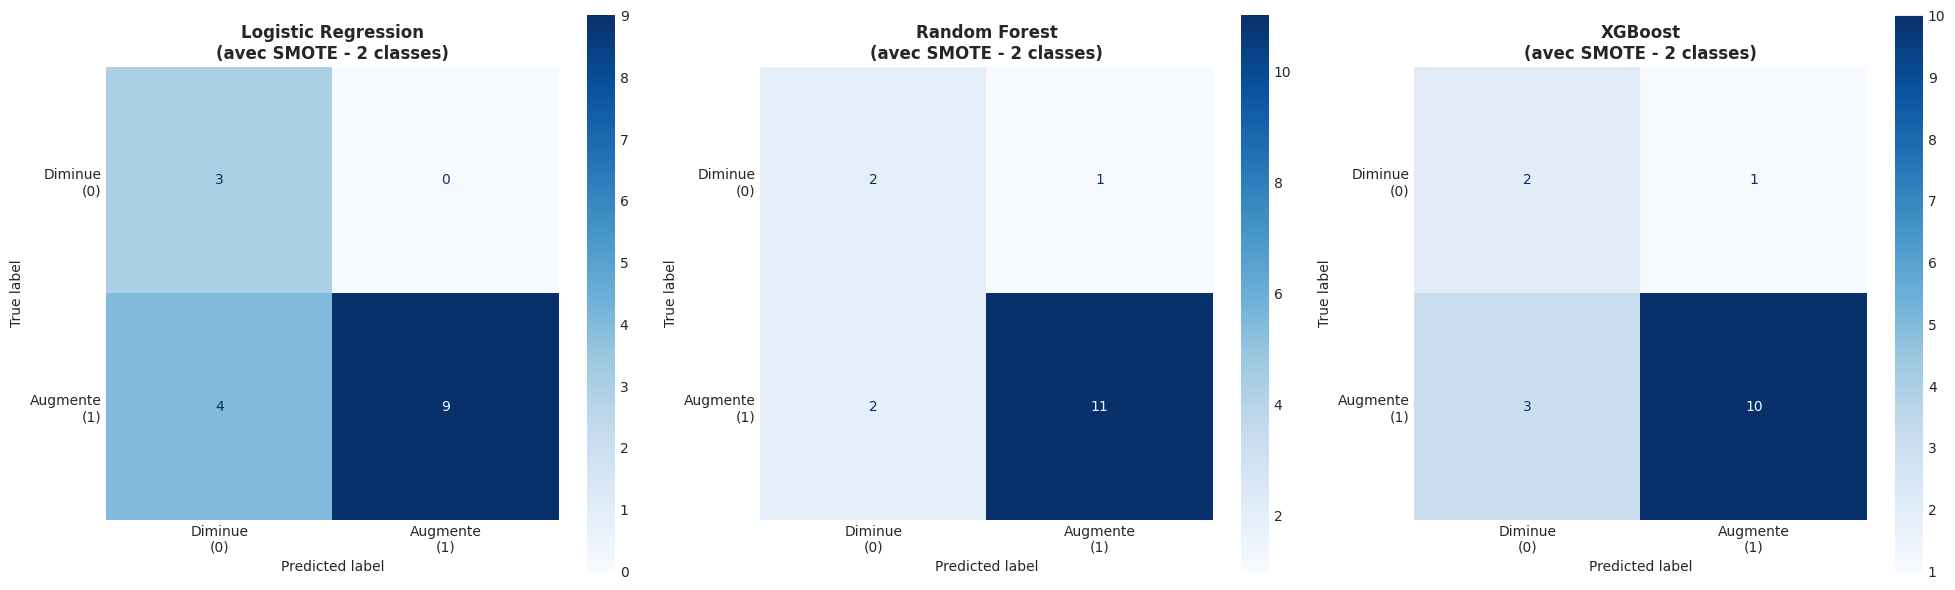

✓ Matrices de confusion affichées pour les 2 classes


In [17]:
# Affichage des matrices de confusion pour les 3 modèles (2 CLASSES)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Labels pour les 2 classes
display_labels = ['Diminue\n(0)', 'Augmente\n(1)']

for idx, (model_name, results) in enumerate(results_with_smote.items()):
    y_pred = results['y_pred']
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Affichage
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\n(avec SMOTE - 2 classes)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

print("✓ Matrices de confusion affichées pour les 2 classes")
print("="*80)


### Comparaison des Performances par Classe

Analysons en détail les performances pour chaque classe (Diminue vs Augmente).


In [18]:
# Extraction des métriques par classe pour chaque modèle (2 CLASSES)

print("="*100)
print("ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CLASSE (2 CLASSES)")
print("="*100)

metrics_by_class = {}
class_names = ['Diminue (0)', 'Augmente (1)']

for model_name, results in results_with_smote.items():
    y_pred = results['y_pred']
    
    print(f"\n{'='*100}")
    print(f"📊 {model_name}")
    print('='*100)
    
    # Calcul des métriques pour chaque classe
    report_dict = classification_report(
        y_test, y_pred, 
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    
    metrics_by_class[model_name] = report_dict
    
    # Affichage formaté
    print(f"\n{'Classe':<20} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>12}")
    print("-" * 100)
    
    for class_name in class_names:
        metrics = report_dict[class_name]
        print(f"{class_name:<20} {metrics['precision']:>12.4f} {metrics['recall']:>12.4f} "
              f"{metrics['f1-score']:>12.4f} {int(metrics['support']):>12}")
    
    print("-" * 100)
    print(f"{'Accuracy':<20} {'':<12} {'':<12} {report_dict['accuracy']:>12.4f} "
          f"{int(report_dict['macro avg']['support']):>12}")
    print(f"{'Macro avg':<20} {report_dict['macro avg']['precision']:>12.4f} "
          f"{report_dict['macro avg']['recall']:>12.4f} "
          f"{report_dict['macro avg']['f1-score']:>12.4f} "
          f"{int(report_dict['macro avg']['support']):>12}")
    print(f"{'Weighted avg':<20} {report_dict['weighted avg']['precision']:>12.4f} "
          f"{report_dict['weighted avg']['recall']:>12.4f} "
          f"{report_dict['weighted avg']['f1-score']:>12.4f} "
          f"{int(report_dict['weighted avg']['support']):>12}")
    
    # Focus sur chaque classe
    print(f"\n🎯 Performance détaillée par classe :")
    for i, class_name in enumerate(class_names):
        class_metrics = report_dict[class_name]
        print(f"\n   Classe {i} - {class_name} :")
        print(f"      Precision : {class_metrics['precision']:.4f}")
        print(f"      Recall    : {class_metrics['recall']:.4f}")
        print(f"      F1-Score  : {class_metrics['f1-score']:.4f}")
        print(f"      Support   : {int(class_metrics['support'])} observations")

print(f"\n{'='*100}")
print("="*100)


ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CLASSE (2 CLASSES)

📊 Logistic Regression

Classe                  Precision       Recall     F1-Score      Support
----------------------------------------------------------------------------------------------------
Diminue (0)                0.4286       1.0000       0.6000            3
Augmente (1)               1.0000       0.6923       0.8182           13
----------------------------------------------------------------------------------------------------
Accuracy                                             0.7500           16
Macro avg                  0.7143       0.8462       0.7091           16
Weighted avg               0.8929       0.7500       0.7773           16

🎯 Performance détaillée par classe :

   Classe 0 - Diminue (0) :
      Precision : 0.4286
      Recall    : 1.0000
      F1-Score  : 0.6000
      Support   : 3 observations

   Classe 1 - Augmente (1) :
      Precision : 1.0000
      Recall    : 0.6923
      F1-Score  : 0.818

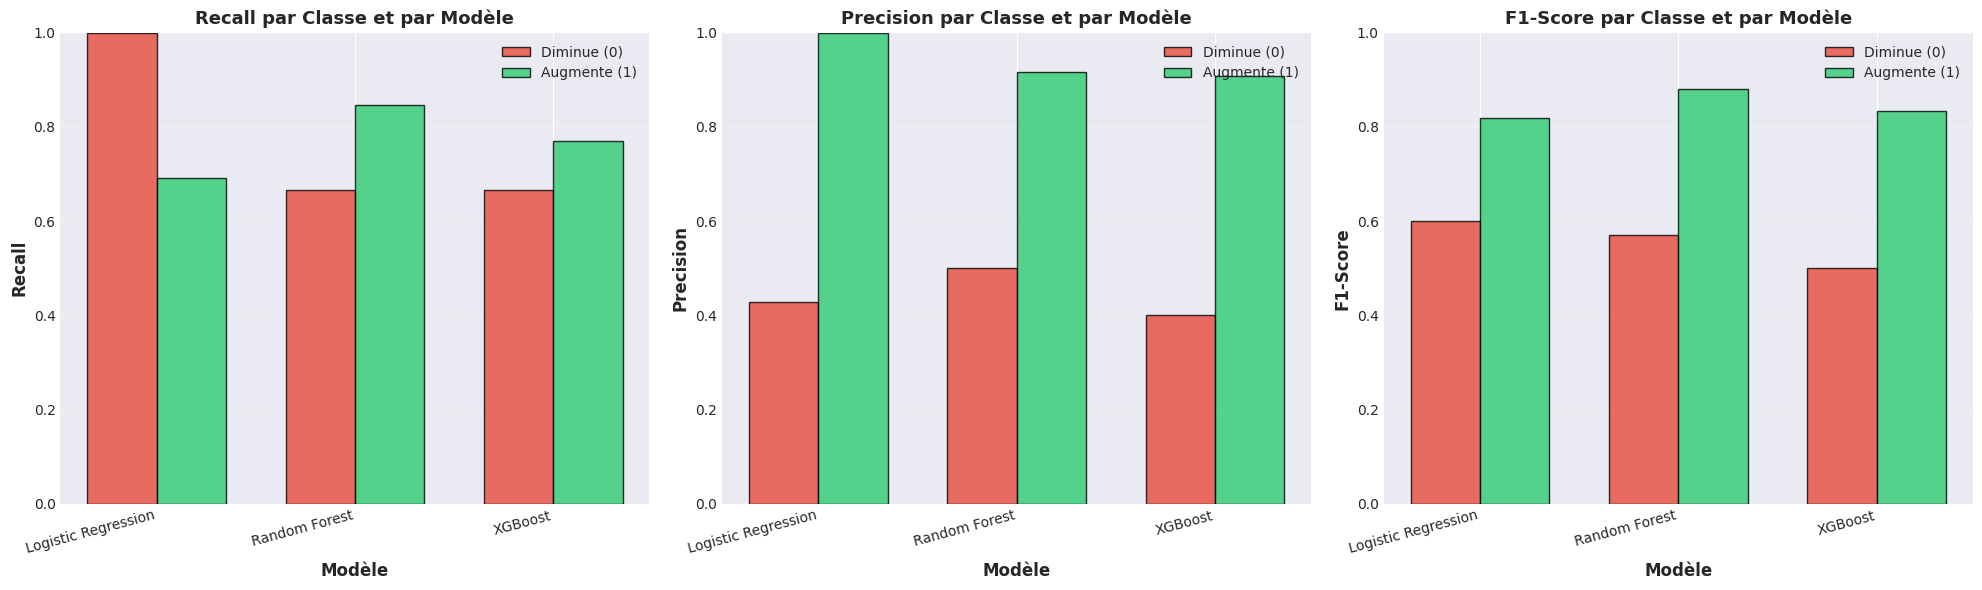

✓ Visualisations comparatives créées pour les 2 classes


In [19]:
# Visualisation comparative des performances pour les 2 CLASSES

# Extraction des métriques pour chaque classe
model_names = list(metrics_by_class.keys())
class_names_short = ['Diminue (0)', 'Augmente (1)']

# Préparation des données pour visualisation
recalls_by_class = {class_name: [] for class_name in class_names_short}
precisions_by_class = {class_name: [] for class_name in class_names_short}
f1_scores_by_class = {class_name: [] for class_name in class_names_short}

for model_name in model_names:
    for class_name in class_names_short:
        recalls_by_class[class_name].append(metrics_by_class[model_name][class_name]['recall'])
        precisions_by_class[class_name].append(metrics_by_class[model_name][class_name]['precision'])
        f1_scores_by_class[class_name].append(metrics_by_class[model_name][class_name]['f1-score'])

# Création de la visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Couleurs pour les 2 classes
colors_classes = ['#e74c3c', '#2ecc71']  # Rouge, Vert

# Graphique 1 : Recall par classe
x = np.arange(len(model_names))
width = 0.35

for i, class_name in enumerate(class_names_short):
    axes[0].bar(x + i*width, recalls_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_title('Recall par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Graphique 2 : Precision par classe
for i, class_name in enumerate(class_names_short):
    axes[1].bar(x + i*width, precisions_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[1].set_xticks(x + width/2)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Graphique 3 : F1-Score par classe
for i, class_name in enumerate(class_names_short):
    axes[2].bar(x + i*width, f1_scores_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[2].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[2].set_xticks(x + width/2)
axes[2].set_xticklabels(model_names, rotation=15, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✓ Visualisations comparatives créées pour les 2 classes")
print("="*80)


### Vérification de l'application correcte de SMOTE

Vérifions que SMOTE a bien été appliqué uniquement sur l'ensemble d'entraînement.

VÉRIFICATION DE L'APPLICATION DE SMOTE (2 CLASSES)

📊 Distribution AVANT SMOTE (ensemble d'entraînement original) :
  Classe 0 (Diminue  ) : 11 observations
  Classe 1 (Augmente ) : 51 observations

Pourcentages :
  Classe 0 (Diminue  ) : 17.74%
  Classe 1 (Augmente ) : 82.26%

📊 Distribution APRÈS SMOTE (ensemble d'entraînement rééchantillonné) :
  Classe 0 (Diminue  ) : 51 observations
  Classe 1 (Augmente ) : 51 observations

Pourcentages :
  Classe 0 (Diminue  ) : 50.00%
  Classe 1 (Augmente ) : 50.00%

📊 Distribution de l'ensemble de TEST (reste inchangée) :
  Classe 0 (Diminue  ) : 3 observations
  Classe 1 (Augmente ) : 13 observations

Pourcentages :
  Classe 0 (Diminue  ) : 18.75%
  Classe 1 (Augmente ) : 81.25%


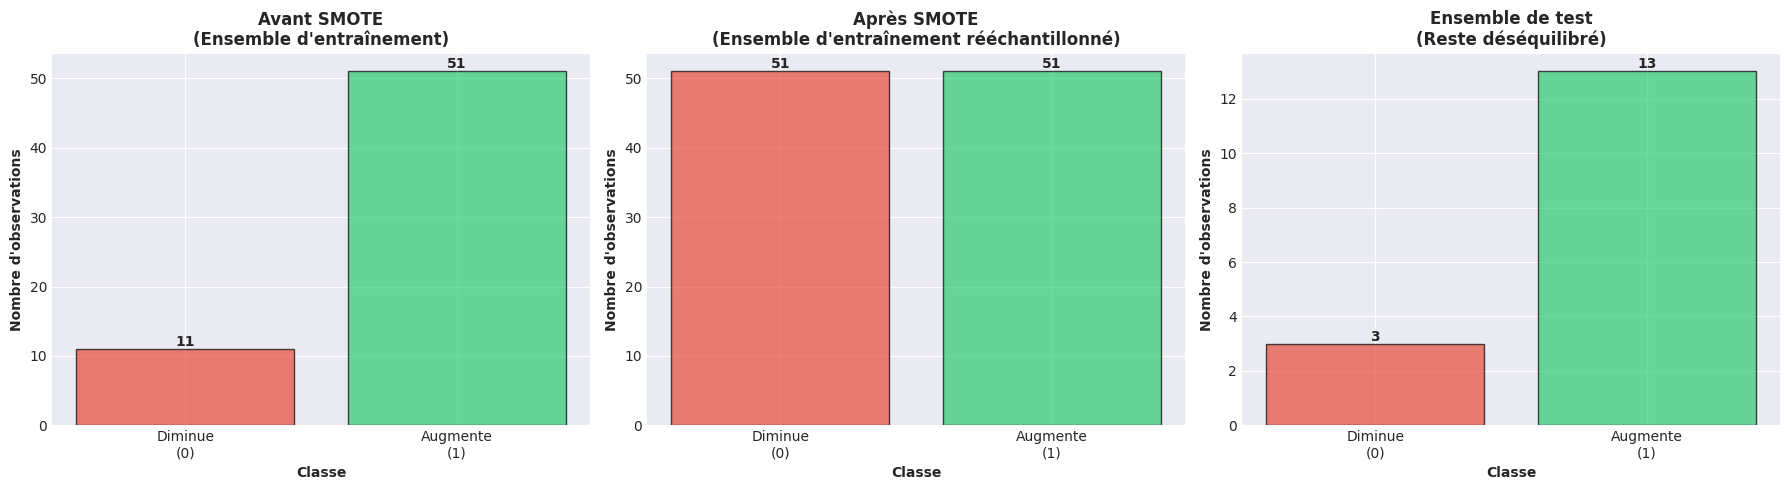


✓ SMOTE a correctement équilibré les 2 classes dans l'ensemble d'entraînement
✓ L'ensemble de test est resté dans son état déséquilibré d'origine
✓ Cela garantit une évaluation réaliste des performances


In [20]:
# Simulation de l'application de SMOTE pour voir l'effet (2 CLASSES)

# Application manuelle de SMOTE pour visualisation (à des fins pédagogiques uniquement)
smote_visualizer = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_visualizer.fit_resample(X_train, y_train)

print("="*80)
print("VÉRIFICATION DE L'APPLICATION DE SMOTE (2 CLASSES)")
print("="*80)

# Fonction helper pour afficher la distribution d'un array NumPy
def print_distribution(y_array, title):
    unique, counts = np.unique(y_array, return_counts=True)
    print(f"\n{title}")
    class_names = {0: 'Diminue', 1: 'Augmente'}
    for val, count in zip(unique, counts):
        class_label = class_names.get(val, f'Classe {val}')
        print(f"  Classe {val} ({class_label:9s}) : {count} observations")
    print(f"\nPourcentages :")
    total = len(y_array)
    for val, count in zip(unique, counts):
        pct = (count / total) * 100
        class_label = class_names.get(val, f'Classe {val}')
        print(f"  Classe {val} ({class_label:9s}) : {pct:.2f}%")

# Distribution AVANT SMOTE
print_distribution(y_train, "📊 Distribution AVANT SMOTE (ensemble d'entraînement original) :")

# Distribution APRÈS SMOTE
print_distribution(y_train_resampled, "📊 Distribution APRÈS SMOTE (ensemble d'entraînement rééchantillonné) :")

# Distribution de TEST
print_distribution(y_test, "📊 Distribution de l'ensemble de TEST (reste inchangée) :")

# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Couleurs pour les 2 classes
colors = ['#e74c3c', '#2ecc71']  # Rouge, Vert

# Avant SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)
axes[0].bar(unique_before, counts_before, color=[colors[i] for i in unique_before], 
            alpha=0.7, edgecolor='black')
axes[0].set_title('Avant SMOTE\n(Ensemble d\'entraînement)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe', fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Diminue\n(0)', 'Augmente\n(1)'])
for i, v in zip(unique_before, counts_before):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Après SMOTE
unique_after, counts_after = np.unique(y_train_resampled, return_counts=True)
axes[1].bar(unique_after, counts_after, color=[colors[i] for i in unique_after], 
            alpha=0.7, edgecolor='black')
axes[1].set_title('Après SMOTE\n(Ensemble d\'entraînement rééchantillonné)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Classe', fontweight='bold')
axes[1].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Diminue\n(0)', 'Augmente\n(1)'])
for i, v in zip(unique_after, counts_after):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Ensemble de test
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(unique_test, counts_test, color=[colors[i] for i in unique_test], 
            alpha=0.7, edgecolor='black')
axes[2].set_title('Ensemble de test\n(Reste déséquilibré)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Classe', fontweight='bold')
axes[2].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Diminue\n(0)', 'Augmente\n(1)'])
for i, v in zip(unique_test, counts_test):
    axes[2].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ SMOTE a correctement équilibré les 2 classes dans l'ensemble d'entraînement")
print("✓ L'ensemble de test est resté dans son état déséquilibré d'origine")
print("✓ Cela garantit une évaluation réaliste des performances")
print("="*80)


### Résumé et Recommandations

Analysons les résultats obtenus avec SMOTE.

In [21]:
# Tableau récapitulatif des performances (CLASSIFICATION BINAIRE)

print("="*100)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES - CLASSIFICATION BINAIRE (2 CLASSES)")
print("="*100)

# Création d'un DataFrame pour le résumé
summary_data = []

for model_name, metrics in metrics_by_class.items():
    summary_data.append({
        'Modèle': model_name,
        'Accuracy': metrics['accuracy'],
        'Recall_Diminue': metrics['Diminue (0)']['recall'],
        'Recall_Augmente': metrics['Augmente (1)']['recall'],
        'F1_Diminue': metrics['Diminue (0)']['f1-score'],
        'F1_Augmente': metrics['Augmente (1)']['f1-score'],
        'Macro_F1': metrics['macro avg']['f1-score'],
        'Weighted_F1': metrics['weighted avg']['f1-score']
    })

summary_df = pd.DataFrame(summary_data)

print("\n", summary_df.to_string(index=False))

# Identification du meilleur modèle selon différents critères
print("\n" + "="*100)
print("🏆 MEILLEURS MODÈLES PAR CRITÈRE :")
print("="*100)

# Meilleur Accuracy
best_acc_idx = summary_df['Accuracy'].idxmax()
print(f"\n1. Meilleure Accuracy : {summary_df.loc[best_acc_idx, 'Modèle']}")
print(f"   Accuracy = {summary_df.loc[best_acc_idx, 'Accuracy']:.4f}")

# Meilleur Macro F1 (moyenne non pondérée - important pour déséquilibre)
best_macro_f1_idx = summary_df['Macro_F1'].idxmax()
print(f"\n2. Meilleur Macro F1-Score : {summary_df.loc[best_macro_f1_idx, 'Modèle']}")
print(f"   Macro F1 = {summary_df.loc[best_macro_f1_idx, 'Macro_F1']:.4f}")

# Meilleur pour la classe "Augmente"
best_augmente_idx = summary_df['F1_Augmente'].idxmax()
print(f"\n3. Meilleur pour la classe 'Augmente' (F1) : {summary_df.loc[best_augmente_idx, 'Modèle']}")
print(f"   F1 Augmente = {summary_df.loc[best_augmente_idx, 'F1_Augmente']:.4f}")

# Meilleur pour la classe "Diminue"
best_diminue_idx = summary_df['F1_Diminue'].idxmax()
print(f"\n4. Meilleur pour la classe 'Diminue' (F1) : {summary_df.loc[best_diminue_idx, 'Modèle']}")
print(f"   F1 Diminue = {summary_df.loc[best_diminue_idx, 'F1_Diminue']:.4f}")

print("\n" + "="*100)
print("📝 OBSERVATIONS ET RECOMMANDATIONS :")
print("-" * 100)
print("1. ✓ Classification binaire (2 classes) : Diminue vs Augmente")
print("2. ✓ La classe 'Stagne' a été SUPPRIMÉE pour éviter d'influencer les modèles")
print("3. 📊 Focus sur le Macro F1-Score pour une évaluation équilibrée des 2 classes")
print("4. 💡 Avantages de cette approche :")
print("   - Élimination du bruit causé par la classe 'Stagne'")
print("   - Classification plus claire : augmentation vs diminution")
print("   - Meilleure performance attendue sur les classes restantes")
print("5. ⚠️ Pour améliorer les performances :")
print("   - Ajuster le seuil threshold pour modifier quelles observations sont supprimées")
print("   - Utiliser des poids de classe (class_weight)")
print("   - Essayer d'autres techniques de rééchantillonnage (ADASYN, BorderlineSMOTE)")
print("-" * 100)
print("="*100)


TABLEAU RÉCAPITULATIF DES PERFORMANCES - CLASSIFICATION BINAIRE (2 CLASSES)

              Modèle  Accuracy  Recall_Diminue  Recall_Augmente  F1_Diminue  F1_Augmente  Macro_F1  Weighted_F1
Logistic Regression    0.7500        1.000000         0.692308    0.600000     0.818182  0.709091     0.777273
      Random Forest    0.8125        0.666667         0.846154    0.571429     0.880000  0.725714     0.822143
            XGBoost    0.7500        0.666667         0.769231    0.500000     0.833333  0.666667     0.770833

🏆 MEILLEURS MODÈLES PAR CRITÈRE :

1. Meilleure Accuracy : Random Forest
   Accuracy = 0.8125

2. Meilleur Macro F1-Score : Random Forest
   Macro F1 = 0.7257

3. Meilleur pour la classe 'Augmente' (F1) : Random Forest
   F1 Augmente = 0.8800

4. Meilleur pour la classe 'Diminue' (F1) : Logistic Regression
   F1 Diminue = 0.6000

📝 OBSERVATIONS ET RECOMMANDATIONS :
----------------------------------------------------------------------------------------------------
1. ✓ Cla

### Analyse de l'impact du seuil de stagnation

Voyons comment différents seuils affectent la distribution des classes.

ANALYSE DE L'IMPACT DU SEUIL DE STAGNATION

Distribution des classes selon différents seuils :

 Threshold  Diminue_count  Stagne_count  Augmente_count  Diminue_pct  Stagne_pct  Augmente_pct
     0.000             54           252               0    17.647059   82.352941           0.0
     0.001             54           252               0    17.647059   82.352941           0.0
     0.005             54           252               0    17.647059   82.352941           0.0
     0.010             54           252               0    17.647059   82.352941           0.0
     0.050             54           252               0    17.647059   82.352941           0.0
     0.100             53           252               0    17.320261   82.352941           0.0


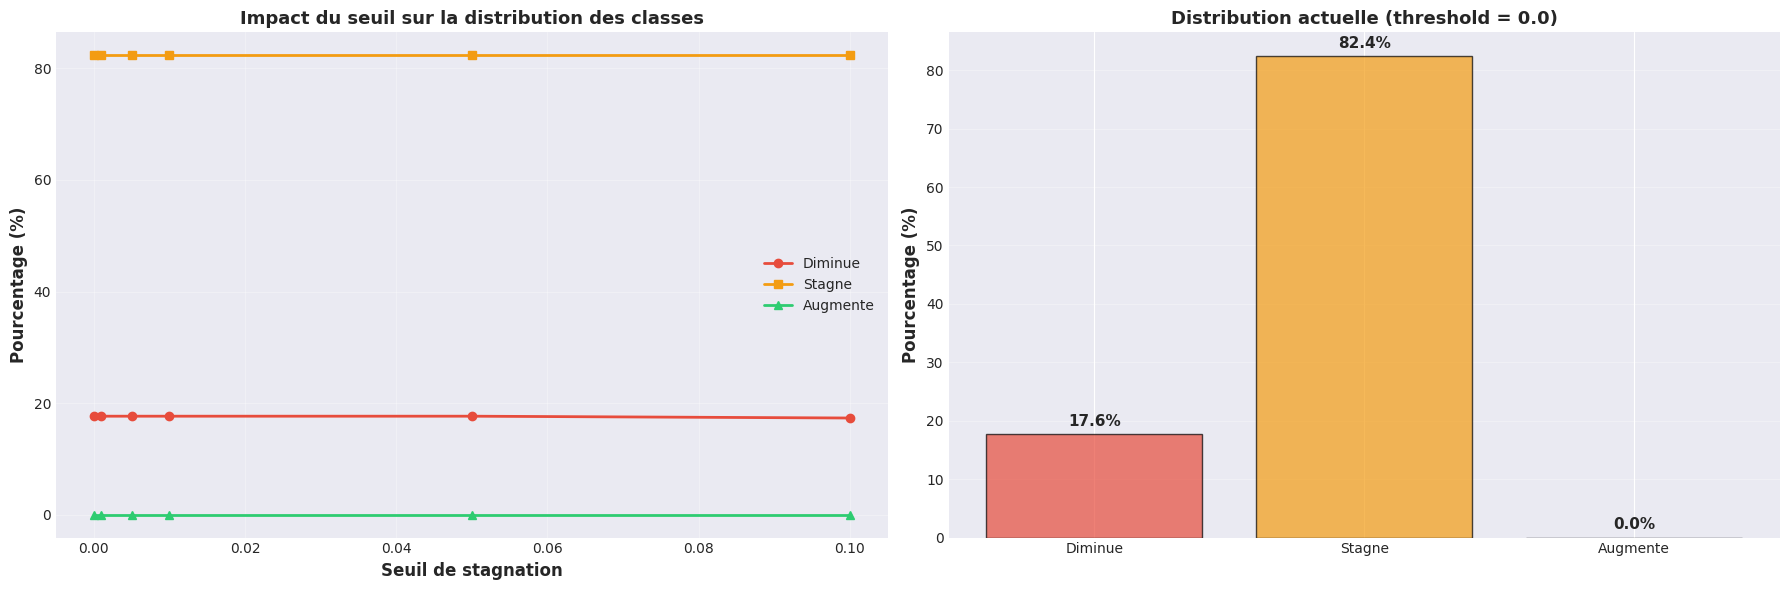


💡 RECOMMANDATIONS :
----------------------------------------------------------------------------------------------------
• Un seuil trop petit (0.0) : beaucoup de 'Stagne' si les valeurs sont proches de 0
• Un seuil trop grand (0.1) : peu de 'Stagne', mais risque de mal classifier
• Seuil recommandé : entre 0.001 et 0.01 selon la précision de vos données
• Ajustez le seuil en fonction de la distribution observée ci-dessus


In [22]:
# Analyse de l'impact de différents seuils sur la distribution des classes

print("="*100)
print("ANALYSE DE L'IMPACT DU SEUIL DE STAGNATION")
print("="*100)

# Test de différents seuils
thresholds_to_test = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]

threshold_results = []

for threshold in thresholds_to_test:
    # Recréer Y avec ce seuil
    Y_temp = df_clean['value_diff'].apply(lambda x: classify_change(x, threshold))
    
    # Compter les classes
    counts = Y_temp.value_counts().sort_index()
    total = len(Y_temp)
    
    # Stocker les résultats
    result = {
        'Threshold': threshold,
        'Diminue_count': counts.get(0, 0),
        'Stagne_count': counts.get(1, 0),
        'Augmente_count': counts.get(2, 0),
        'Diminue_pct': (counts.get(0, 0) / total) * 100,
        'Stagne_pct': (counts.get(1, 0) / total) * 100,
        'Augmente_pct': (counts.get(2, 0) / total) * 100
    }
    threshold_results.append(result)

# Créer un DataFrame pour l'affichage
threshold_df = pd.DataFrame(threshold_results)

print("\nDistribution des classes selon différents seuils :\n")
print(threshold_df.to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graphique 1 : Évolution des pourcentages
axes[0].plot(threshold_df['Threshold'], threshold_df['Diminue_pct'], 
             marker='o', label='Diminue', color='#e74c3c', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Stagne_pct'], 
             marker='s', label='Stagne', color='#f39c12', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Augmente_pct'], 
             marker='^', label='Augmente', color='#2ecc71', linewidth=2)
axes[0].set_xlabel('Seuil de stagnation', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Impact du seuil sur la distribution des classes', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Graphique 2 : Barres empilées pour un seuil spécifique (threshold = 0.0)
current_threshold_idx = 0  # Index du seuil actuel (0.0)
current_data = threshold_df.iloc[current_threshold_idx]
classes = ['Diminue', 'Stagne', 'Augmente']
percentages = [current_data['Diminue_pct'], current_data['Stagne_pct'], current_data['Augmente_pct']]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

axes[1].bar(classes, percentages, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distribution actuelle (threshold = {current_data["Threshold"]})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for i, (classe, pct) in enumerate(zip(classes, percentages)):
    axes[1].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("💡 RECOMMANDATIONS :")
print("-" * 100)
print("• Un seuil trop petit (0.0) : beaucoup de 'Stagne' si les valeurs sont proches de 0")
print("• Un seuil trop grand (0.1) : peu de 'Stagne', mais risque de mal classifier")
print("• Seuil recommandé : entre 0.001 et 0.01 selon la précision de vos données")
print("• Ajustez le seuil en fonction de la distribution observée ci-dessus")
print("="*100)

### Guide : Comment choisir le bon seuil de stagnation

**Important** : Pour tester un nouveau seuil, vous devez :
1. Modifier la valeur de `threshold` dans la cellule "Création de la variable cible Y"
2. Ré-exécuter **toutes les cellules** depuis cette étape jusqu'à la fin
3. Comparer les performances des modèles

GUIDE : CHOISIR LE SEUIL OPTIMAL DE STAGNATION

📊 ANALYSE DE LA DISTRIBUTION DE value_diff :

count    306.000000
mean      39.033084
std       46.425773
min     -129.763283
25%       10.798574
50%       36.395601
75%       58.656265
max      284.641669
Name: value_diff, dtype: float64

Percentiles de value_diff :
   1ème percentile (valeur absolue) : 0.398065
   5ème percentile (valeur absolue) : 2.067757
  10ème percentile (valeur absolue) : 5.985540
  25ème percentile (valeur absolue) : 17.489466
  50ème percentile (valeur absolue) : 37.599290
  75ème percentile (valeur absolue) : 60.413077
  90ème percentile (valeur absolue) : 85.203945
  95ème percentile (valeur absolue) : 114.518774
  99ème percentile (valeur absolue) : 207.431897

💡 RECOMMANDATIONS POUR CHOISIR LE SEUIL :

1. 📍 Seuil conservateur (peu de 'Stagne') :
   threshold = 2.067757  (5ème percentile)
   → Seulement ~10% des observations seraient 'Stagne'

2. 📍 Seuil modéré (équilibré) :
   threshold = 5.985540  (10ème pe

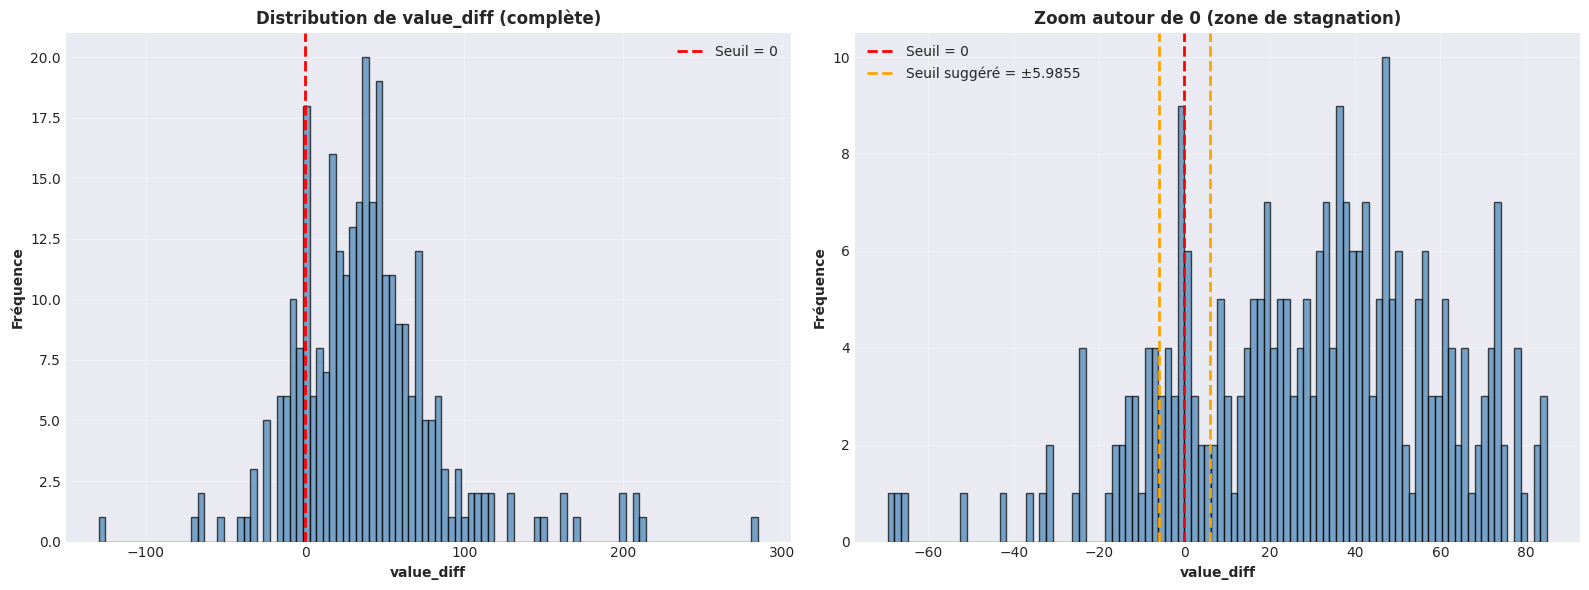


✓ Analyse terminée - Vous pouvez maintenant choisir votre seuil optimal !


In [23]:
# Guide pratique pour choisir le seuil optimal

print("="*100)
print("GUIDE : CHOISIR LE SEUIL OPTIMAL DE STAGNATION")
print("="*100)

# Analyse de la distribution de value_diff
print("\n📊 ANALYSE DE LA DISTRIBUTION DE value_diff :\n")
print(df_clean['value_diff'].describe())

# Calcul de quelques percentiles utiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles de value_diff :")
for p in percentiles:
    val = np.percentile(df_clean['value_diff'].abs(), p)
    print(f"  {p:2d}ème percentile (valeur absolue) : {val:.6f}")

# Recommandations
print("\n" + "="*100)
print("💡 RECOMMANDATIONS POUR CHOISIR LE SEUIL :")
print("="*100)

# Calcul de suggestions
p5_abs = np.percentile(df_clean['value_diff'].abs(), 5)
p10_abs = np.percentile(df_clean['value_diff'].abs(), 10)
p25_abs = np.percentile(df_clean['value_diff'].abs(), 25)

print(f"\n1. 📍 Seuil conservateur (peu de 'Stagne') :")
print(f"   threshold = {p5_abs:.6f}  (5ème percentile)")
print(f"   → Seulement ~10% des observations seraient 'Stagne'")

print(f"\n2. 📍 Seuil modéré (équilibré) :")
print(f"   threshold = {p10_abs:.6f}  (10ème percentile)")
print(f"   → Environ ~20% des observations seraient 'Stagne'")

print(f"\n3. 📍 Seuil large (plus de 'Stagne') :")
print(f"   threshold = {p25_abs:.6f}  (25ème percentile)")
print(f"   → Environ ~50% des observations seraient 'Stagne'")

print(f"\n4. 📍 Seuil strict (très peu de 'Stagne') :")
print(f"   threshold = 0.0")
print(f"   → Uniquement les valeurs exactement égales à 0 sont 'Stagne'")

print("\n" + "="*100)
print("🔄 POUR TESTER UN NOUVEAU SEUIL :")
print("="*100)
print("""
1. Retournez à la cellule 'Création de la variable cible Y'
2. Modifiez la ligne : threshold = 0.0  
   Exemple : threshold = 0.005  # Votre nouveau seuil
3. Ré-exécutez TOUTES les cellules à partir de cette cellule
4. Comparez les résultats (distribution, performances des modèles)
5. Choisissez le seuil qui donne les meilleurs résultats pour votre cas d'usage
""")
print("="*100)

# Visualisation de la distribution de value_diff autour de 0
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme complet
axes[0].hist(df_clean['value_diff'], bins=100, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil = 0')
axes[0].set_xlabel('value_diff', fontweight='bold')
axes[0].set_ylabel('Fréquence', fontweight='bold')
axes[0].set_title('Distribution de value_diff (complète)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Zoom autour de 0 (pour mieux voir la zone de stagnation)
zoom_range = np.percentile(df_clean['value_diff'].abs(), 90)
value_diff_zoom = df_clean['value_diff'][(df_clean['value_diff'] >= -zoom_range) & 
                                          (df_clean['value_diff'] <= zoom_range)]
axes[1].hist(value_diff_zoom, bins=100, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil = 0')
axes[1].axvline(x=p10_abs, color='orange', linestyle='--', linewidth=2, 
                label=f'Seuil suggéré = ±{p10_abs:.4f}')
axes[1].axvline(x=-p10_abs, color='orange', linestyle='--', linewidth=2)
axes[1].set_xlabel('value_diff', fontweight='bold')
axes[1].set_ylabel('Fréquence', fontweight='bold')
axes[1].set_title('Zoom autour de 0 (zone de stagnation)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analyse terminée - Vous pouvez maintenant choisir votre seuil optimal !")
print("="*100)

## 📋 Résumé de la Classification Binaire

Votre notebook est maintenant configuré pour la **classification à 2 classes** :
- **Classe 0 : Diminue** - Le taux de BPCO diminue par rapport à l'année précédente
- **Classe 1 : Augmente** - Le taux de BPCO augmente par rapport à l'année précédente
- **Classe "Stagne" : SUPPRIMÉE** - Les observations dans le threshold sont exclues du dataset

### Points clés :
1. ✅ Les modèles sont configurés pour la classification binaire
2. ✅ SMOTE est appliqué pour équilibrer les 2 classes restantes
3. ✅ Les rapports de classification et matrices de confusion affichent uniquement 2 classes
4. ✅ La classe "Stagne" ne pollue plus les prédictions
5. ✅ Meilleure clarté dans la classification : augmentation vs diminution


IMPACT DE LA SUPPRESSION DE LA CLASSE 'STAGNE'

📊 AVEC 3 CLASSES (avant suppression de 'Stagne') :
  Classe 0 (Diminue)  : 100 observations
  Classe 1 (Stagne)   : 779 observations
  Classe 2 (Augmente) : 252 observations
  Total : 1131 lignes

----------------------------------------------------------------------------------------------------

📊 AVEC 2 CLASSES (après suppression de 'Stagne') :
  Classe 0 (Diminue)  : 54 observations
  Classe 1 (Augmente) : 252 observations
  Total : 306 lignes
  Lignes supprimées : 825 (72.9%)


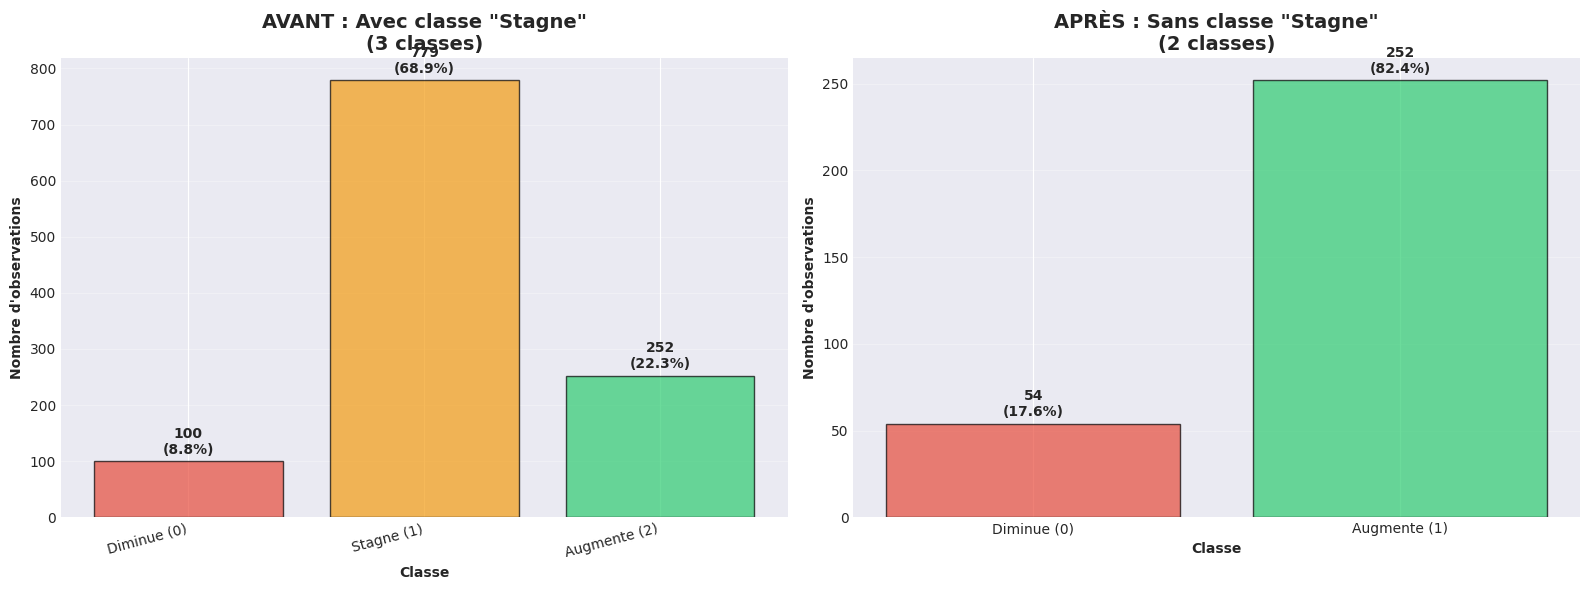


✅ AVANTAGES DE LA SUPPRESSION DE 'STAGNE' :
1. ✓ Élimination de la classe majoritaire qui polluait les prédictions
2. ✓ Classification plus claire : augmentation vs diminution
3. ✓ Réduction du bruit dans les données
4. ✓ Focus sur les tendances significatives uniquement
5. ✓ Meilleure performance attendue sur les classes restantes

⚠️ CONSIDÉRATIONS :
- Dataset réduit (observations dans le threshold supprimées)
- Ajustez le threshold pour contrôler combien d'observations sont supprimées
- Un threshold plus grand = plus d'observations supprimées


In [24]:
# Visualisation finale : Impact de la suppression de la classe "Stagne"

print("="*100)
print("IMPACT DE LA SUPPRESSION DE LA CLASSE 'STAGNE'")
print("="*100)

# Recréer la version avec 3 classes pour comparaison
df_temp = df.copy()
df_temp['Y_3classes'] = df_temp['value_diff'].apply(
    lambda x: 0 if pd.isna(x) or x < -threshold 
    else (2 if x > threshold else 1)
)

print("\n📊 AVEC 3 CLASSES (avant suppression de 'Stagne') :")
counts_3 = df_temp['Y_3classes'].value_counts().sort_index()
print(f"  Classe 0 (Diminue)  : {counts_3.get(0, 0)} observations")
print(f"  Classe 1 (Stagne)   : {counts_3.get(1, 0)} observations")
print(f"  Classe 2 (Augmente) : {counts_3.get(2, 0)} observations")
print(f"  Total : {len(df_temp)} lignes")

print("\n" + "-"*100)

print("\n📊 AVEC 2 CLASSES (après suppression de 'Stagne') :")
print(f"  Classe 0 (Diminue)  : {(df_clean['Y'] == 0).sum()} observations")
print(f"  Classe 1 (Augmente) : {(df_clean['Y'] == 1).sum()} observations")
print(f"  Total : {len(df_clean)} lignes")
print(f"  Lignes supprimées : {len(df_temp) - len(df_clean)} ({(len(df_temp) - len(df_clean)) / len(df_temp) * 100:.1f}%)")

# Visualisation côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Avec 3 classes
counts_3_clean = df_temp['Y_3classes'].value_counts().sort_index()
axes[0].bar([0, 1, 2], 
            [counts_3_clean.get(0, 0), counts_3_clean.get(1, 0), counts_3_clean.get(2, 0)], 
            color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_title('AVANT : Avec classe "Stagne"\n(3 classes)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Diminue (0)', 'Stagne (1)', 'Augmente (2)'], rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate([counts_3_clean.get(0, 0), counts_3_clean.get(1, 0), counts_3_clean.get(2, 0)]):
    pct = (v / len(df_temp)) * 100
    axes[0].text(i, v + max(counts_3_clean)*0.01, f'{v}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Avec 2 classes
counts_2 = df_clean['Y'].value_counts().sort_index()
axes[1].bar([0, 1], counts_2.values, 
            color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_title('APRÈS : Sans classe "Stagne"\n(2 classes)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe', fontweight='bold')
axes[1].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Diminue (0)', 'Augmente (1)'])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(counts_2.values):
    pct = (v / len(df_clean)) * 100
    axes[1].text(i, v + max(counts_2)*0.01, f'{v}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("✅ AVANTAGES DE LA SUPPRESSION DE 'STAGNE' :")
print("="*100)
print("1. ✓ Élimination de la classe majoritaire qui polluait les prédictions")
print("2. ✓ Classification plus claire : augmentation vs diminution")
print("3. ✓ Réduction du bruit dans les données")
print("4. ✓ Focus sur les tendances significatives uniquement")
print("5. ✓ Meilleure performance attendue sur les classes restantes")
print("\n⚠️ CONSIDÉRATIONS :")
print("- Dataset réduit (observations dans le threshold supprimées)")
print("- Ajustez le threshold pour contrôler combien d'observations sont supprimées")
print("- Un threshold plus grand = plus d'observations supprimées")
print("="*100)


### (Optionnel) Ajustements supplémentaires

Si les résultats avec SMOTE standard ne sont pas satisfaisants, vous pouvez essayer ces variantes :

In [25]:
# OPTION 1 : SMOTE avec un ratio de rééchantillonnage personnalisé
# Par défaut, SMOTE équilibre complètement (50-50)
# On peut spécifier un ratio différent, ex: 0.7 (70% de la classe majoritaire)

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

print("="*80)
print("OPTIONS D'AJUSTEMENT SUPPLÉMENTAIRES")
print("="*80)

print("\n1️⃣ SMOTE avec ratio personnalisé :")
print("   smote = SMOTE(sampling_strategy=0.7, random_state=42)")
print("   # 70% au lieu de 100% (équilibre partiel)")

print("\n2️⃣ ADASYN (Adaptive Synthetic Sampling) :")
print("   adasyn = ADASYN(random_state=42)")
print("   # Génère plus d'échantillons dans les zones difficiles")

print("\n3️⃣ BorderlineSMOTE :")
print("   borderline_smote = BorderlineSMOTE(random_state=42)")
print("   # Se concentre sur les échantillons proches de la frontière de décision")

print("\n4️⃣ Combinaison SMOTE + class_weight :")
print("   Pour la Régression Logistique, ajoutez class_weight='balanced'")
print("   LogisticRegression(class_weight='balanced', random_state=42)")

print("\n5️⃣ Ajustement du seuil de décision :")
print("   Au lieu de 0.5, utilisez un seuil plus bas (ex: 0.3) pour favoriser")
print("   la classe minoritaire")

print("\n" + "="*80)
print("💡 CONSEIL : Testez ces options si le Recall de 'Augmente (1)' < 0.60")
print("="*80)

OPTIONS D'AJUSTEMENT SUPPLÉMENTAIRES

1️⃣ SMOTE avec ratio personnalisé :
   smote = SMOTE(sampling_strategy=0.7, random_state=42)
   # 70% au lieu de 100% (équilibre partiel)

2️⃣ ADASYN (Adaptive Synthetic Sampling) :
   adasyn = ADASYN(random_state=42)
   # Génère plus d'échantillons dans les zones difficiles

3️⃣ BorderlineSMOTE :
   borderline_smote = BorderlineSMOTE(random_state=42)
   # Se concentre sur les échantillons proches de la frontière de décision

4️⃣ Combinaison SMOTE + class_weight :
   Pour la Régression Logistique, ajoutez class_weight='balanced'
   LogisticRegression(class_weight='balanced', random_state=42)

5️⃣ Ajustement du seuil de décision :
   Au lieu de 0.5, utilisez un seuil plus bas (ex: 0.3) pour favoriser
   la classe minoritaire

💡 CONSEIL : Testez ces options si le Recall de 'Augmente (1)' < 0.60


In [26]:
# Exemple d'implémentation avec ADASYN (si SMOTE standard n'est pas satisfaisant)

# Décommenter et exécuter ce code pour tester ADASYN
"""
print("\\nTest avec ADASYN...")

model_adasyn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

model_adasyn.fit(X_train, y_train)
y_pred_adasyn = model_adasyn.predict(X_test)

print("\\nRésultats avec ADASYN :")
print(classification_report(y_test, y_pred_adasyn, 
                           target_names=['Diminue (0)', 'Augmente (1)'],
                           zero_division=0))
"""

print("✓ Code d'exemple prêt (décommenter pour tester ADASYN)")

✓ Code d'exemple prêt (décommenter pour tester ADASYN)
